# Solving PDEs with Jax

This file contains our first approach to solve PDEs with neural networks on the Jax Library.  
We will try to solve the poisson Equation :  
$-\Delta u(x) = f(x)$ on $\Omega = [0,1]^2$  
With Dirichlet homogeneous boundary conditions $u|_{\partial \Omega}=0$ and $f(x_1, x_2)=2\pi^2 sin(\pi x_1) sin(\pi x_2)$

The loss to minimize here is $\mathcal{L} = ||\Delta u(x) + f(x)||_2$, the MSE of the PDE  
The true function $u$ should be $u(x_1, x_2)=sin(\pi x_1) sin(\pi x_2)$

# Importing libraries

In [7]:
from jax import grad, value_and_grad,jvp
from jax import vmap 
from functools import partial 
from jax import jit 
from jax import random as jran
import jax.numpy as jnp
from jax.experimental import optimizers as jax_opt
from jax.nn import relu
from time import time
import matplotlib.pyplot as plt
import numpy as np

# Fonctions to create and manipulate the Multilayer Perceptrons

In [8]:
def MLP_create(layers,key):
    params = []
    keys = jran.split(key, len(layers))
    for layer in range(0, len(layers)-1):
        W = MLP_init((layers[layer], layers[layer+1]), keys[layer])
        #b = jnp.zeros((layers[layer+1],1), dtype=np.float32)
        b=jran.truncated_normal(key, -1, 1, shape=(layers[layer+1], 1), dtype=np.float32)
        params.append((W,b))
    return params

def MLP_init(size, key): 
    in_size,out_size=size[0],size[1]
    std_dev = jnp.sqrt(2/(in_size + out_size ))
    return jran.truncated_normal(key, -2, 2, shape=(out_size, in_size), dtype=np.float32)*std_dev
    
def MLP_init2(size, key): 
    in_size,out_size=size[0],size[1]
    std_dev = jnp.sqrt(2/(in_size + out_size ))
    key, sub_key = jran.split(key)
    weights = jran.uniform(sub_key, shape=(out_size, in_size), minval=-1, maxval=1)
    return weights

@jit
def net_apply(params, X):
    for layer in range(0, len(params)-1):
        W, b = params[layer]
        X = relu(jnp.add(jnp.dot(X, W.T), b))
    W, b = params[-1]
    Y = jnp.dot(X, W.T)+ b
    return Y

# Definition of the target, laplacian and loss function

In [9]:
@jit    
def target_function(X):
    return 2*jnp.pi**2*jnp.sin(jnp.pi*X[:,0])*jnp.sin(jnp.pi*X[:,1])
    
@jit
def laplacian(f,X):
  @jit
  def hessian_bilinear_form(f, x, u, v):
    # forward-over-reverse autodiff
    f_jvp = lambda x: jvp(f, (x,), (u,))[1]
    return jvp(f_jvp, (x,), (v,))[1]
  @jit
  def hessian_entry(f, x, i, j):
    u = jnp.zeros_like(x).at[i].set(1)
    v = jnp.zeros_like(x).at[j].set(1)
    return hessian_bilinear_form(f, x, u, v)

  preds=[]
  for i in range(X.shape[0]):
    lap=hessian_entry(f, X[i,:], 0, 0)+hessian_entry(f, X[i,:], 1, 1)+hessian_entry(f, X[i,:], 2, 2)
    preds.append(lap.sum())
  return jnp.asarray(preds)

@jit
def loss_function(params, X_tbatch,targets):
    preds=vmap(partial(net_apply, params))(X_tbatch)[:,0,0]
    return jnp.linalg.norm(preds+targets)


# Determining NN parameters

In [10]:
opt_init, opt_update, get_params = jax_opt.adam(0.0005)

n_features, n_targets = 2, 1
layers = [n_features,30,30,n_targets]

SEED = 0
key = jran.PRNGKey(SEED)
params = MLP_create(layers, key)
opt_state=opt_init(params)

# Train step function and parameters

In [11]:
batch_size = 2500
num_batches = 10000
report_steps=50
loss_history = []

@jit
def train_step(i, opt_state, x, y):
    params = get_params(opt_state)
    loss, gradient = value_and_grad(loss_function)(params, x, y)
    return loss, opt_update(i, gradient, opt_state)

# Solving PDE

In [12]:
#from math import inf
#error,loss=0.01,inf
#ibatch=0
#while loss>=error:
for ibatch in range(num_batches):
    ran_key, batch_key = jran.split(key)
    X_train = jran.uniform(batch_key, shape=(batch_size, n_features), minval=0, maxval=1)
    targets = target_function(X_train)
    loss, opt_state = train_step(ibatch, opt_state, X_train,targets)
    loss_history.append(float(loss))

    if ibatch%report_steps==report_steps-1:
        print("Epoch n°{}: ".format(ibatch+1), loss.item())
    ibatch+=1

Epoch n°50:  479.3174743652344
Epoch n°100:  477.25897216796875
Epoch n°150:  470.8067626953125
Epoch n°200:  460.8252868652344
Epoch n°250:  447.443115234375
Epoch n°300:  429.8576354980469
Epoch n°350:  405.4482421875
Epoch n°400:  374.2221374511719
Epoch n°450:  339.1541748046875
Epoch n°500:  310.6742248535156
Epoch n°550:  293.4241943359375
Epoch n°600:  279.95086669921875
Epoch n°650:  265.58111572265625
Epoch n°700:  247.92245483398438
Epoch n°750:  226.15345764160156
Epoch n°800:  198.79193115234375
Epoch n°850:  167.86026000976562
Epoch n°900:  135.3846893310547
Epoch n°950:  104.11573028564453
Epoch n°1000:  76.77037811279297
Epoch n°1050:  55.829524993896484
Epoch n°1100:  41.424346923828125
Epoch n°1150:  30.982210159301758
Epoch n°1200:  25.611339569091797
Epoch n°1250:  22.98508071899414
Epoch n°1300:  21.63683319091797
Epoch n°1350:  20.79470443725586
Epoch n°1400:  20.041048049926758
Epoch n°1450:  19.12076759338379
Epoch n°1500:  18.34400177001953
Epoch n°1550:  17.340

# Plot loss function

<function matplotlib.pyplot.show(close=None, block=None)>

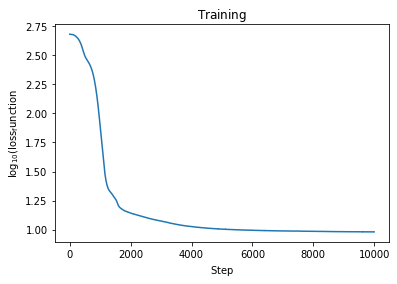

In [13]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(np.log10(loss_history))
xlabel = ax.set_xlabel(r'${\rm Step}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss_function}$')
title = ax.set_title(r'${\rm Training}$')
plt.show

# Approximate solution

(-0.049989551305770874,
 1.0500069081783296,
 -0.0499981701374054,
 1.049998289346695)

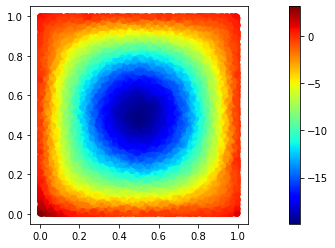

In [14]:
plt.figure()
params=get_params(opt_state)
n_points=100000
ran_key, batch_key = jran.split(key)
X_train = jran.uniform(batch_key, shape=(n_points, n_features), minval=0, maxval=1)

predictions = vmap(partial(net_apply, params))(X_train)[:,0,0]
plt.scatter(X_train[:,0],X_train[:,1], c=predictions, cmap="jet",linewidths=0.00000000001)
plt.colorbar()
plt.axis("square")

# Real solution

(-0.049989551305770874,
 1.0500069081783296,
 -0.0499981701374054,
 1.049998289346695)

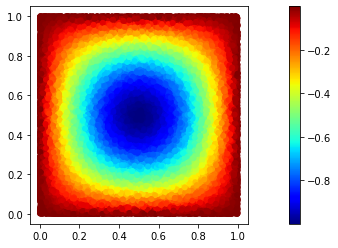

In [15]:
def real_solution(X):
    return -jnp.sin(jnp.pi*X[:,0])*jnp.sin(jnp.pi*X[:,1])

plt.figure()
params=get_params(opt_state)
n_points=100000
ran_key, batch_key = jran.split(key)
X_train = jran.uniform(batch_key, shape=(n_points, n_features), minval=0, maxval=1)

predictions = real_solution(X_train)
plt.scatter(X_train[:,0],X_train[:,1], c=predictions, cmap="jet",linewidths=0.00000000001)
plt.colorbar()
plt.axis("square")

# Save NN parameters

In [16]:
file_data = open("params_jax.csv",'w')
file_data.write(str(params))
file_data.close()

file_data = open("opt_state_jax.csv",'w')
file_data.write(str(opt_state))
file_data.close()